# Processing

This notebook tries several processing methods on the dataset.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
filepath = 'movie_metadata.csv'

# Dropping columns

In [4]:
df = pd.read_csv(filepath)
tf=pd.read_csv('testdata.csv')

# Drop features
to_drop = ['country', 'language', 'movie_imdb_link']
df.drop(to_drop, axis=1, inplace=True)
tf.drop(to_drop, axis=1, inplace=True)

# Imputing dataset, filling null values

a table that indicates the number of missing values in each coloumn

In [5]:
null_counts = [(col, df[col].isnull().sum()) for col in df]
pd.DataFrame(null_counts, columns=['feature', 'null_cnt']).sort_values(by='null_cnt', ascending=False)

,feature,null_cnt
8,gross,884
19,budget,492
23,aspect_ratio,329
18,content_rating,303
16,plot_keywords,153
20,title_year,108
1,director_name,104
4,director_facebook_likes,104
2,num_critic_for_reviews,50
5,actor_3_facebook_likes,23


In [6]:
print(df)

                 color       director_name  num_critic_for_reviews  duration  \
0                Color       James Cameron                   723.0     178.0   
1                Color      Gore Verbinski                   302.0     169.0   
2                Color          Sam Mendes                   602.0     148.0   
3                Color   Christopher Nolan                   813.0     164.0   
4                  NaN         Doug Walker                     NaN       NaN   
5                Color      Andrew Stanton                   462.0     132.0   
6                Color           Sam Raimi                   392.0     156.0   
7                Color        Nathan Greno                   324.0     100.0   
8                Color         Joss Whedon                   635.0     141.0   
9                Color         David Yates                   375.0     153.0   
10               Color         Zack Snyder                   673.0     183.0   
11               Color        Bryan Sing

For numeric values, fill nulls with the median
for categorical, fill nulls with the most common value of that category

In [53]:
features_text = sorted(df.dtypes[df.dtypes == 'object'].index.values.tolist())
features_numeric = sorted(set(df.columns) - set(features_text))

In [13]:
def get_all_items_and_most_common(series):
    nested_list = series.apply(lambda x: x.split('|') if not type(x) == float else []).values
    all_items = pd.Series(np.hstack(nested_list))
    unique_items = all_items.unique()
    return sorted(unique_items), all_items.value_counts().index[0]

In [14]:
keywords, mc_keyword = get_all_items_and_most_common(df.plot_keywords)
genres, mc_genre = get_all_items_and_most_common(df.genres)
directors, mc_director = get_all_items_and_most_common(df.director_name)

In [15]:
for col in features_numeric:
    med = df[col].median()
    df[col].fillna(med, inplace=True)

In [16]:
for col in ['actor_1_name', 'actor_2_name', 'actor_3_name', 'color', 'content_rating', 'director_name']:
    most_common_value = df[col].value_counts().index[0]
    df[col].fillna(most_common_value, inplace=True)
df.plot_keywords.fillna(mc_keyword, inplace=True)

In [17]:
# no more nulls
len(df) - len(df.dropna())

0


# Working on features 



For plot_keywords, genres, actors, directors calculate average score given to the items.



In [30]:
def get_item_scores(df, items, column):
    item_scores = {item: [] for item in items}
    for ix, row in df.iterrows():
        if type(row[column]) == str:
            for item in row[column].split('|'):
                item_scores[item].append(row.imdb_score)
    return item_scores

In [31]:
keyword_scores = get_item_scores(df, keywords, 'plot_keywords')
genre_scores = get_item_scores(df, genres, 'genres')
director_scores = get_item_scores(df, directors, 'director_name')

In [57]:
keyword_scores1 = get_item_scores(tf, keywords, 'plot_keywords')
genre_scores1 = get_item_scores(tf, genres, 'genres')
director_scores1 = get_item_scores(tf, directors, 'director_name')

In [32]:
all_actors = df.actor_1_name.values.tolist() + df.actor_2_name.values.tolist() + df.actor_3_name.values.tolist()
actors = sorted(set(all_actors))

actor_scores = {actor: [] for actor in actors}
for ix, row in df.iterrows():
    for a in [row.actor_1_name, row.actor_2_name, row.actor_3_name]:
        if type(a) == str:
            actor_scores[a].append(row.imdb_score)

In [33]:
def get_average_scores(scores):
    ave_scores = dict()
    for key, scores in scores.items():
        ave_scores[key] = sum(scores) / len(scores)
    return ave_scores

keyword_ave_scores = get_average_scores(keyword_scores)
genre_ave_scores = get_average_scores(genre_scores)
actor_ave_scores = get_average_scores(actor_scores)
director_ave_scores = get_average_scores(director_scores)

In [34]:
df.loc[:, 'actor_1_ave_score'] = df.actor_1_name.apply(lambda name: actor_ave_scores[name])
df.loc[:, 'actor_2_ave_score'] = df.actor_2_name.apply(lambda name: actor_ave_scores[name])
df.loc[:, 'actor_3_ave_score'] = df.actor_3_name.apply(lambda name: actor_ave_scores[name])
splitted = df.genres.apply(lambda s: s.split('|'))
df.loc[:, 'genres_ave_score'] = splitted.apply(lambda genres: sum([genre_ave_scores[g] for g in genres]) / len(genres))
splitted = df.plot_keywords.apply(lambda s: s.split('|'))
df.loc[:, 'keywords_ave_score'] = splitted.apply(lambda keywords: sum([keyword_ave_scores[k] for k in keywords]) / len(keywords))
df.loc[:, 'director_ave_score'] = df.director_name.apply(lambda name: director_ave_scores[name])

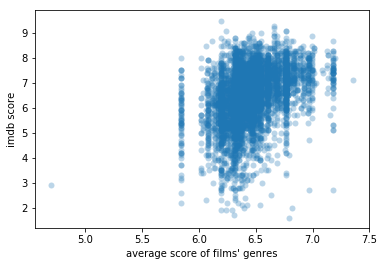

In [35]:
plt.scatter(df.genres_ave_score, df.imdb_score, lw=0, alpha=0.3)
plt.xlabel('average score of films\' genres')
plt.ylabel('imdb score');


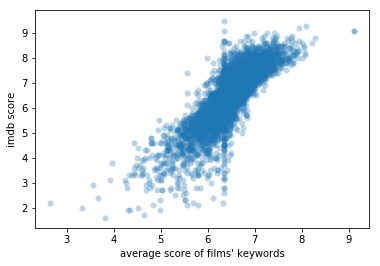

In [36]:
plt.scatter(df.keywords_ave_score, df.imdb_score, lw=0, alpha=0.3)
plt.xlabel('average score of films\' keywords')
plt.ylabel('imdb score');

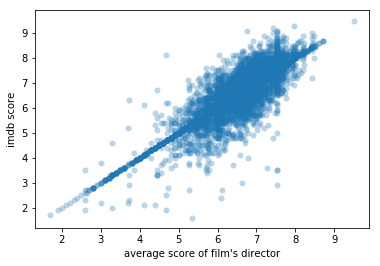

In [37]:
# For directors with only one movie, we have the straight line
plt.scatter(df.director_ave_score, df.imdb_score, lw=0, alpha=0.3)
plt.xlabel('average score of film\'s director')
plt.ylabel('imdb score');

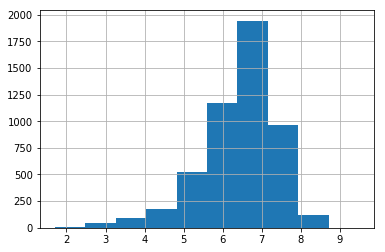

In [38]:
df.director_ave_score.hist()

## One Hot encoding for color and content_rating

 For the categorical features, we include them in input by converting to one hot encoding

In [39]:
from sklearn import preprocessing

In [40]:
def label_encode_transform(series):
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(series)
    return label_encoder.transform(series)

def one_hot_encode(series):
    one_hot_encoder = preprocessing.OneHotEncoder()
    inp = label_encode_transform(series)
    inp = inp.reshape(-1, 1)
    one_hot_encoder.fit(inp)
    one_hot = one_hot_encoder.transform(inp)
    return one_hot.toarray()


In [41]:
X_color = one_hot_encode(df.color)
X_rating = one_hot_encode(df.content_rating)
X_color1 = one_hot_encode(tf.color)
X_rating1 = one_hot_encode(tf.content_rating)

C:\anaconda 4\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\anaconda 4\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder befo

In [58]:
X_numeric = df[['num_critic_for_reviews', 'duration', 'director_facebook_likes', 'actor_3_facebook_likes', 'actor_1_facebook_likes',
   'gross', 'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster', 'num_user_for_reviews',
   'budget', 'title_year', 'actor_2_facebook_likes', 'actor_1_ave_score', 'actor_2_ave_score', 'actor_3_ave_score',
   'genres_ave_score', 'keywords_ave_score', 'director_ave_score']].values

X_numeric1 = tf[['num_critic_for_reviews', 'duration', 'director_facebook_likes', 'actor_3_facebook_likes', 'actor_1_facebook_likes',
   'gross', 'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster', 'num_user_for_reviews',
   'budget', 'title_year', 'actor_2_facebook_likes']].values

KeyError: "['actor_1_ave_score' 'actor_2_ave_score' 'actor_3_ave_score'\n 'genres_ave_score' 'keywords_ave_score' 'director_ave_score'] not in index"

## Combining all inputs

In [43]:
X = np.hstack([X_numeric, X_color, X_rating])
T= np.hstack([X_numeric1, X_color1, X_rating1])
y = df.imdb_score.values

## Regression on the whole dataset

In [28]:
from sklearn import model_selection
from sklearn import linear_model

Splitting dataset into training and testing data

In [29]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=0)

## Linear regression

In [30]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
# mean square error
print('Linear regression error')
np.mean((regr.predict(X_test) - y_test) ** 2)

Linear regression error


0.14529837538525023

In [31]:
# base-line for mean-square error
np.mean((np.random.rand(len(y_test)) * 10. - y_test) ** 2)

11.71058335989439

If for each sample a random guess between 1 and 10 is given, then the mean square error becomes ~11. The model's error is ~0.1. 

In [33]:
def plot_actual_vs_prediction(predicted, actual):
    plt.figure(figsize=(5, 5))
    plt.scatter(predicted, actual, lw=0, alpha=0.5)
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.plot([0, 10], [0, 10], color='red', lw=2, linestyle='--')
    plt.xlim([0, 10])
    plt.ylim([0, 10])

Plotting actual value vs predicted value

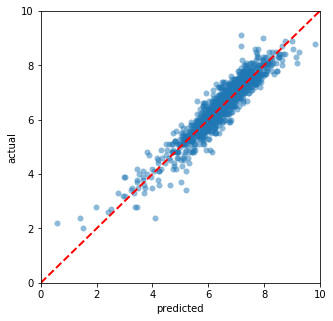

In [34]:
plot_actual_vs_prediction(regr.predict(X_test), y_test)


## K-Neighbours

In [35]:
from sklearn import neighbors

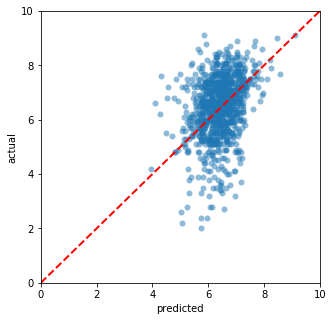

In [36]:
knr = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance', algorithm='kd_tree', leaf_size=60)
knr.fit(X_train, y_train)
plot_actual_vs_prediction(knr.predict(X_test), y_test)

In [38]:
print('K-Neighbors regression error')
np.mean((knr.predict(X_test) - y_test) ** 2)

K-Neighbors regression error


1.1860927923976752

## Random forest

In [39]:
from sklearn import ensemble

C:\anaconda 4\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


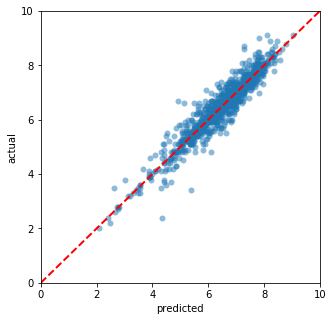

In [40]:
rfr = ensemble.RandomForestRegressor()
rfr.fit(X_train, y_train)
plot_actual_vs_prediction(rfr.predict(X_test), y_test)

In [41]:
print('K-Neighbors regression error')
np.mean((rfr.predict(X_test) - y_test) ** 2)

K-Neighbors regression error


0.12189058473736368

In [42]:
print('K-Neighbors regression error')
np.mean((rfr.predict(X_test) - y_test) ** 2)

K-Neighbors regression error


0.12189058473736368

In [44]:
# Try on the whole dataset
rfr = ensemble.RandomForestRegressor()
predicted = model_selection.cross_val_predict(rfr, X, y, cv=10)

C:\anaconda 4\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\anaconda 4\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\anaconda 4\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\anaconda 4\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\anaconda 4\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will ch

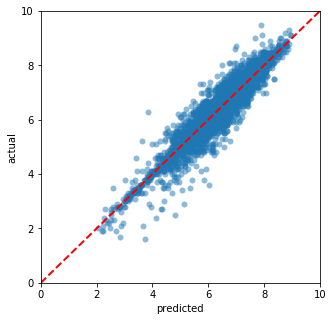

In [45]:
plot_actual_vs_prediction(predicted, y)

In [46]:
np.mean((predicted - y) ** 2)

0.12437457862383502

## Principal Component Analysis

We do principal component analysis in order to reduce dimensionality.

In [48]:
from sklearn import decomposition

In [49]:
pca = decomposition.PCA()
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

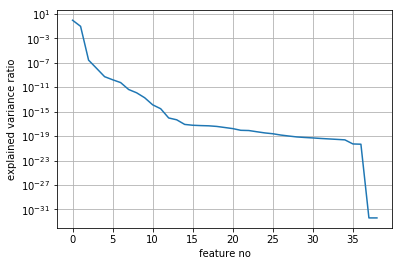

In [50]:
plt.semilogy(pca.explained_variance_ratio_)
plt.grid()
plt.xlabel('feature no')
plt.ylabel('explained variance ratio');

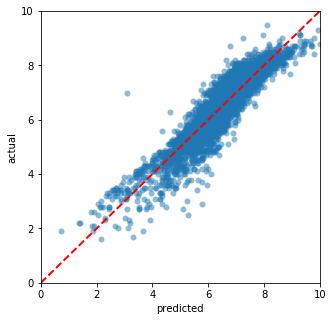

In [51]:
# Try fewer dimensions
X2 = pca.transform(X)[:, :15]
lr = linear_model.LinearRegression()
predicted = model_selection.cross_val_predict(lr, X2, y, cv=10)
plot_actual_vs_prediction(predicted, y)

C:\anaconda 4\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\anaconda 4\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\anaconda 4\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\anaconda 4\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\anaconda 4\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will ch

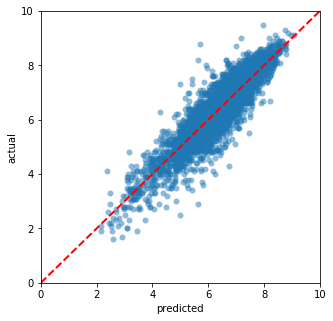

In [52]:
X2 = pca.transform(X)[:, :15]
rfr = ensemble.RandomForestRegressor()
predicted = model_selection.cross_val_predict(rfr, X2, y, cv=10)
plot_actual_vs_prediction(predicted, y)

## Comments

We developed a method for developing new features from plot keywords, genres, director and actor names. They helped a lot in predicting the IMDB score.
The scores calculated on this notebook are misleading because we do our training and testing over whole dataset. Let's split training and test sets and train a model via training set and evaluate its prediction capacity over the test set.

In [7]:
np.array(df)

array([['Color', 'James Cameron', 723.0, ..., 7.9, 1.78, 33000],
       ['Color', 'Gore Verbinski', 302.0, ..., 7.1, 2.35, 0],
       ['Color', 'Sam Mendes', 602.0, ..., 6.8, 2.35, 85000],
       ...,
       ['Color', 'Benjamin Roberds', 13.0, ..., 6.3, nan, 16],
       ['Color', 'Daniel Hsia', 14.0, ..., 6.3, 2.35, 660],
       ['Color', 'Jon Gunn', 43.0, ..., 6.6, 1.85, 456]], dtype=object)